In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [2]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)


In [3]:
df_path = "../merged_data/BCI_USRECD.csv"
features = ["BCI", "BCIp", "BCIg"]
model_names = ["Logistic Regression", "Penalized SVM", "Random Forest"]
get_models = [lambda: linear_model.LogisticRegression(), lambda: svm.SVC(kernel='linear', class_weight='balanced', probability=True), 
          lambda: RandomForestClassifier()]


In [4]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv(df_path)
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date", drop=True)
df = df.drop(columns="Unnamed: 0")
df.head()

,BCI,BCIp,BCIg,USRECD
Date,,,,
1967-02-09,4.6052,6.5870,3.4751,0
1967-02-16,4.6052,6.5863,3.4751,0
1967-02-23,4.6012,6.5774,3.4751,0
1967-03-02,4.6032,6.5820,3.4751,0
1967-03-09,4.6042,6.5852,3.4751,0


In [5]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 21 # This is the lag we introduce to the target variable so that we assess the indicator's 
              # ability to predict the target variable this many steps into the future.
              # With BCI, a lag of 21 data points corresponds to about half a year.
        
X_train, y_train = df.iloc[:-lag_of_y, df.columns != "USRECD"], df.iloc[lag_of_y:, df.columns == "USRECD"]

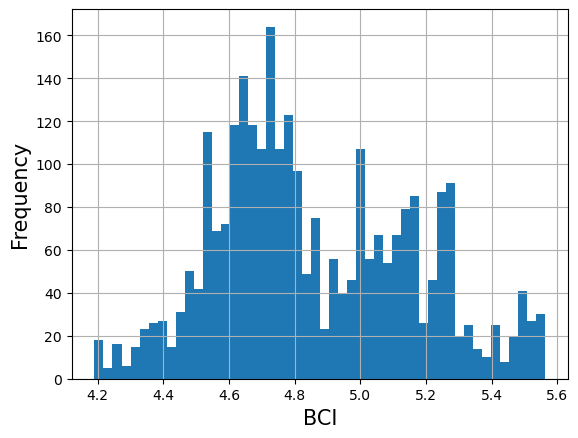

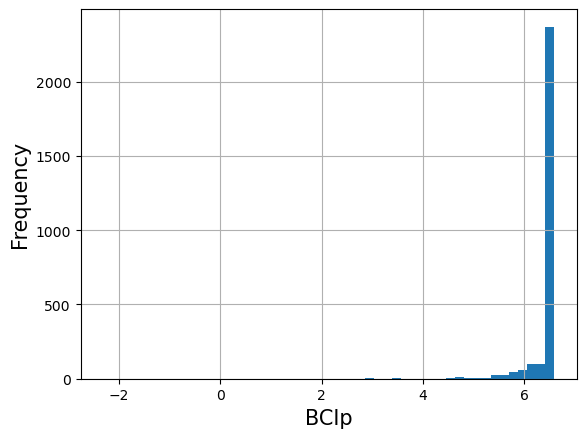

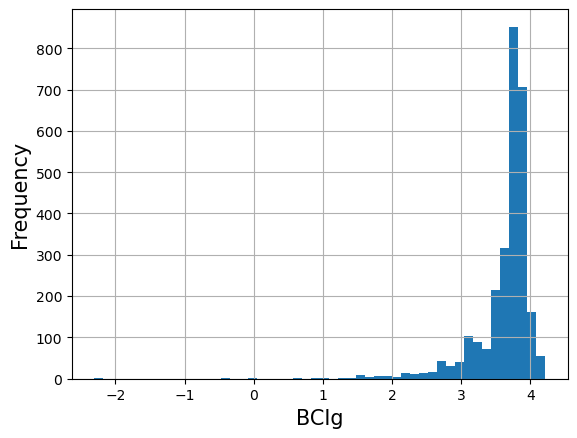

In [6]:
for feature in features:
    plt.figure()
    X_train[feature].hist(bins = 50)
    plt.xlabel(feature,fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()

In [7]:
# Do a time series cross-validation on the test set by splitting it to k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 4 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)

for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29 ... 529 530 531 532 533
 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558] TEST: [ 559  560  561  562  563  564  565  566  567  568  569  570  571  572
  573  574  575  576  577  578  579  580  581  582  583  584  585  586
  587  588 ... 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
 1110 1111 1112 1113]
TRAIN: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29 ... 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
 1110 1111 1112 1113] TEST: [1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125 1126 1127
 1128 1129 1130 1131 1132 1133 113

## Validation

In [8]:
AUC_ROCs = dict()
ACCs = dict()
for model_name, get_model in zip(model_names, get_models):
    print(model_name)
    AUC_ROCs[model_name] = 0
    ACCs[model_name] = 0
    for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
        X_train_fold, X_validation_fold = X_train.iloc[train_index[:-lag_of_y], X_train.columns != "USRECD"], \
            X_train.iloc[test_index[:-lag_of_y], X_train.columns != "USRECD"]
        y_train_fold, y_validation_fold = y_train.iloc[train_index[lag_of_y:], y_train.columns == "USRECD"], \
            y_train.iloc[test_index[lag_of_y:], y_train.columns == "USRECD"]
            
        scalers = dict()
        for feature in features:
            scalers[feature] = StandardScaler()
            scalers[feature].fit(X_train_fold[[feature]])
            X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
            X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]])
            
        model = get_model()
        model.fit(X_train_fold[features], y_train_fold["USRECD"])
        positive_probs = [p[1] for p in model.predict_proba(X_validation_fold[features])]
        AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
        AUC_ROCs[model_name] += AUC_ROC
        predictions = model.predict(X_validation_fold[features])
        ACC = accuracy_score(y_validation_fold, predictions)
        ACCs[model_name] += ACC
        print(AUC_ROC, ACC)
        
    AUC_ROCs[model_name] /= splits
    ACCs[model_name] /= splits

Logistic Regression
0.5015705550893179 0.8333333333333334
0.5625536787861437 0.5767790262172284
0.7883673512286381 0.7790262172284644
0.8716981132075471 0.9925093632958801
Penalized SVM
0.4970627023138713 0.7209737827715356
0.6530775837389063 0.20786516853932585
0.7542934017194627 0.6928838951310862
0.679245283018868 0.7734082397003745
Random Forest
0.7229708668025416 0.7734082397003745
0.8855425135986258 0.4250936329588015
0.9040316986525971 0.8239700374531835
0.5596698113207547 0.9644194756554307


In [9]:
for model_name in model_names:
    print(model_name)
    print(f"AUC ROC: {AUC_ROCs[model_name]}")
    print(f"accuracy: {ACCs[model_name]}")

Logistic Regression
AUC ROC: 0.6810474245779118
accuracy: 0.7954119850187266
Penalized SVM
AUC ROC: 0.6459197426977771
accuracy: 0.5987827715355806
Random Forest
AUC ROC: 0.7680537225936298
accuracy: 0.7467228464419475
